# Generation of human readable but anonymous IDs

Here's an implementation of unique human readable IDs, similar to CUAL-ID  (Ref. https://dx.doi.org/10.1128/mSystems.00010-15) but with improvements, for example, we may use the [Damerau Levenshtein distance](https://en.wikipedia.org/wiki/Damerau%E2%80%93Levenshtein_distance). This is likely to be a lot more error resistant than the Hamming distance actually used in the CUAL-ID python implementation (see https://github.com/johnchase/cual-id/issues/28).

Here's a summary of some string "edit distance" functions which might be useful for correction of common errors:
  * `DamerauLevenshtein` - additions, deletions, substitutions, and transpositions
  * `Levenshtein` - additions, deletions, substitutions
  * `Hamming` - substitutions only

In [1]:
using StringDistances
using UUIDs

#=
module HRIDs

struct HRID{N} <: AbstractString
    chars::SVector{Char,N}
end

end
=#

# Very loosely based on the CUAL-ID python code.
#
# HRID = "human readable ID"

to_base32_char(d) = 'a' + d - 73*(d>=26)

to_hrid_16(uuid, len) = string(uuid)[end-len+1:end]

function to_hrid_32(u::UUID, len)
    # RFC4648 digits
    base = 32
    logbase = 5
    maxdigit = base-1
    u = UInt(u.value % (base^len))
    a = Vector{UInt8}(len)
    for i = len:-1:1
        a[i] = to_base32_char(u & maxdigit)
        u >>= logbase
    end
    return String(a)
end

function to_hrid_26(u::UUID, len)
    # Alphabetical only
    base = 26
    maxdigit = base-1
    u = UInt(u.value % (base^len))
    a = Vector{UInt8}(len)
    for i = len:-1:1
        a[i] = 'a' + (u % base)
        u = div(u, base)
    end
    return String(a)
end

function at_least_distance(dist_type, query, existing, d)
    for e in existing
        if evaluate(dist_type, query, e) < d
            return false
        end
    end
    return true
end

"""
Create a set of `n` random ids using the function `make_hrid`, avoiding being any closer
than `min_distance` from a set of `existing_ids`, according to the distance
function `dist_type`.

Returns pairs of `(hrid,uuid)`, where `hrid` is a "human readable id", constituting
the first `n` elements of the associated UUID.

NOTE: You should use `min_distance >= 3` to allow a single transcription error to be corrected.
"""
function create_ids(n, make_hrid, existing_ids=String[];
                    min_distance=3,
                    failure_threshold=0.99,
                    dist_type=DamerauLevenshtein(),
                    )
    hrids = copy(existing_ids)
    uuids = UUID[]
    initial_hrid_len = length(hrids)
    failures = 0
    trys = 1
    results = []
    while length(hrids) - initial_hrid_len < n
        if failures/trys > failure_threshold
            error("Could not create $n additional unique ids of length $n ($failures failures of $trys trials)")
        end
        trys += 1
        hrid, uuid = make_hrid()
        if at_least_distance(dist_type, hrid, hrids, min_distance)
            push!(uuids, uuid)
            push!(hrids, hrid)
            push!(results, (hrid, uuid))
        else
            failures += 1
        end
    end
    results
end


create_ids

This creates IDs like the following:

In [2]:
function rand_hrid(id_length)
    uuid = uuid4()
    hrid = string(uuid)[end-id_length+1:end]
    hrid = to_hrid_16(uuid, id_length)
    (hrid,uuid)
end

ids = create_ids(100, ()->rand_hrid(5))

display(reshape([h for (h,u) in ids], 20,5))

20×5 Matrix{String}:
 "724b9"  "d22f3"  "ee0cc"  "bd284"  "7feb6"
 "86004"  "e9427"  "bd669"  "7ea7e"  "a558c"
 "0053f"  "ae631"  "1b5bd"  "9faa5"  "b28e2"
 "d7ac5"  "d0a23"  "45058"  "7e6bc"  "2b6cc"
 "902a1"  "58af8"  "db405"  "2e9dc"  "8e7d1"
 "42e35"  "ddb74"  "5444d"  "fdb1b"  "da4a0"
 "431e8"  "7a96f"  "aad66"  "79382"  "d1368"
 "266a8"  "0779d"  "6fdd6"  "10943"  "f67ce"
 "ad232"  "465ef"  "aa224"  "1145d"  "d8520"
 "c7f86"  "1a498"  "11f20"  "6d0a4"  "2b732"
 "090e2"  "496f5"  "a65f8"  "36c1a"  "31de7"
 "51f9c"  "3cf61"  "86225"  "6bf65"  "74cda"
 "fa11e"  "01448"  "81ba4"  "2c1c6"  "5ad8a"
 "79f77"  "6915a"  "1baa9"  "f05a3"  "c0106"
 "87db3"  "49563"  "de19f"  "b82fc"  "adcd9"
 "9b0af"  "92297"  "a8e25"  "f9b6c"  "382dd"
 "c2c70"  "7e500"  "9c10e"  "47818"  "4c07b"
 "c879b"  "b7c24"  "7e954"  "d3b81"  "4639d"
 "e06bd"  "815c5"  "14f81"  "a3f79"  "51d5e"
 "6c7fe"  "3ca98"  "c39b5"  "b4195"  "9b86a"

Unfortunately I'd say it's questionable whether these are really *human readable*.

A better approach might be a simple generative model for "English like" words.  For example, generating a Markov transition matrix from a name corpus such as the following:

In [4]:
using Distributions
using Plots

names=String[]
# Name corups from
# https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/male.txt
# https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/female.txt
#
# Also interesting, much larger corpus:
# https://www.cs.cmu.edu/Groups/AI/areas/nlp/corpora/names/other/names.txt
for line in vcat(readlines("male.txt"), readlines("female.txt"))
    if isempty(line) || first(line) == "#"
        continue
    end
    append!(names, lowercase.(split(line, r"[^a-z]"i)))
end

# Build (right) stochastic matrix
# https://en.wikipedia.org/wiki/Stochastic_matrix<Paste>
char_to_ind(c) = c - 'a' + 1

nletters = 26
nstates = nletters
#end_ind = nletters+1
start_letter_freqs = zeros(Int, nletters)
transition_freqs = zeros(Int, nstates,nstates)
for name in names
    isempty(name) && continue
    start_letter_freqs[char_to_ind(name[1])] += 1
    for i = 1:length(name)-1
        i1 = char_to_ind(name[i])
        i2 = char_to_ind(name[nextind(name,i)])
        transition_freqs[i1,i2] += 1
    end
    # End state
    # transition_freqs[char_to_ind(last(name)),end_ind] += 1
end

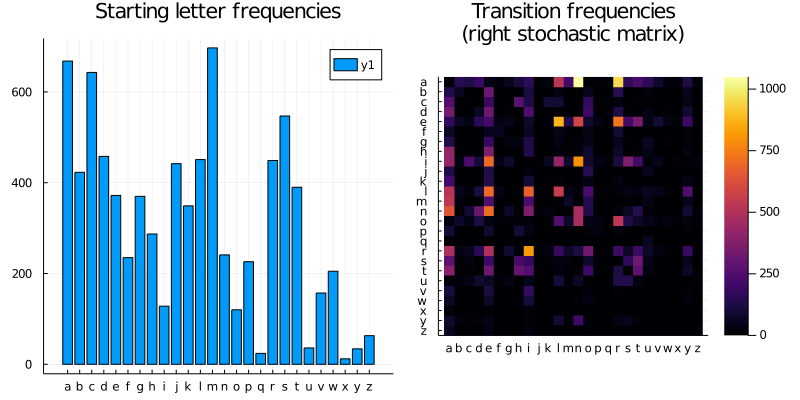

In [5]:
# Plot Markov chain transition probabilities

plot(
    bar(1:nletters, start_letter_freqs,
        xticks=(1:nletters, string.((0:25) .+ 'a')),
        title="Starting letter frequencies"
    ),
    heatmap(transition_freqs,
        aspect_ratio=:equal,
        yticks=(1:nletters, string.((0:25) .+ 'a')),
        xticks=(1:nletters, string.((0:25) .+ 'a')),
        title="Transition frequencies\n(right stochastic matrix)",
        yflip=true
    ),
    size=(800,400),
)

In [6]:
start_letter_dist = Categorical(start_letter_freqs ./ sum(start_letter_freqs))
pairwise_dists = [Categorical(transition_freqs[i,:] ./ sum(transition_freqs[i,:])) for i = 1:nletters]

start_letter_sampler = sampler(start_letter_dist)
pairwise_samplers = sampler.(pairwise_dists)

"""
Create a word-like ID of total length `id_length` with `suffix_numbers` numbers on the end.
Do this by running a Markov chain with the transition probabilities given above.
"""
function markov_hrid(id_length, suffix_numbers=0)
    nameinds = Int[]
    cind = rand(start_letter_sampler)
    push!(nameinds, cind)
    for i=1:id_length-suffix_numbers-1
        cind = rand(pairwise_samplers[cind])
        push!(nameinds, cind)
    end
    name = join('a' .+ nameinds .- 1)
    name = uppercase(name[1])*name[2:end]
    if suffix_numbers != 0
        # Add some numbers for extra entropy
        name = name*join(string.(rand(0:9,suffix_numbers)))
    end
    name
end

# Execute Markov chain to build some name-like words
names = [markov_hrid(6) for _=1:25]
names = sort(names)
display(reshape(names, (5,5)))

5×5 Matrix{String}:
 "Almial"  "Delele"  "Hochaj"  "Nandal"  "Rysodd"
 "Antrla"  "Fesste"  "Iceric"  "Nelynn"  "Shtele"
 "Bbitel"  "Gallee"  "Lyliku"  "Pheers"  "Tidian"
 "Ciasti"  "Giniax"  "Mielan"  "Prqutt"  "Toncey"
 "Ciedon"  "Goiest"  "Mmisie"  "Riulen"  "Wrnnys"

We can also use this to generate unique names sufficiently different from the rest of the list, using `create_ids`:

In [7]:
dummy=uuid4()
ids = create_ids(100, ()->(markov_hrid(4),dummy))
display(reshape([h for (h,u) in ids], 20,5))

20×5 Matrix{String}:
 "Mily"  "Chat"  "Deor"  "Amaz"  "Rdrl"
 "Kena"  "Rste"  "Dico"  "Llcq"  "Dgyl"
 "Kism"  "Nnis"  "Mmpp"  "Tivi"  "Quto"
 "Rldi"  "Ccke"  "Yllp"  "Grul"  "Aurd"
 "Merm"  "Dsus"  "Newe"  "Wonc"  "Elfl"
 "Erer"  "Jova"  "Hott"  "Eyse"  "Acho"
 "Sare"  "Klin"  "Wyal"  "Esha"  "Pime"
 "Modr"  "Evod"  "Adec"  "Beyb"  "Fydy"
 "Thob"  "Gwai"  "Edit"  "Lika"  "Epan"
 "Dada"  "Frie"  "Tago"  "Izeu"  "Dosy"
 "Wies"  "Pant"  "Ssif"  "Lmil"  "Ciol"
 "Kami"  "Fest"  "Ckyv"  "Maun"  "Glos"
 "Riar"  "Xori"  "Tthe"  "Velu"  "Xwye"
 "Hall"  "Muic"  "Fffr"  "Folg"  "Bylt"
 "Bbia"  "Ahle"  "Inay"  "Brso"  "Lsoo"
 "Rnon"  "Suel"  "Stty"  "Ngut"  "Bumu"
 "Anng"  "Atya"  "Oven"  "Drth"  "Jude"
 "Iemo"  "Trrg"  "Ginn"  "Bscl"  "Jeti"
 "Rynd"  "Wrli"  "Teac"  "Orbu"  "Ceed"
 "Phra"  "Cach"  "Fleb"  "Gusk"  "Cqui"